In [1]:
# install in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/ahmed-h-elsheikh/polychaos-learn
    %cd polychaos-learn
    !pwd
    !pip install .

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import random
import time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV

from pclearn import OrthogonalPolynomialsFeatures

In [3]:
def fix_random_seed(seed_):
    random.seed(seed_)
    np.random.seed(seed_)

def ish_2d(x):
    # Ishigami Function in 2D
    x_0 = x[:, 0]
    x_1 = x[:, 1]
    term1 = 2.0 * x_0 + 0.1 * np.sin(2.0 * x_0)
    term2 = -3.28 * x_1 + 7.0 * np.multiply(np.sin(x_1), np.sin(x_1)) - 3.5
    y = term1 + term2
    return y

def load_ish_data(n_samples, rand_seed_):
    # generate data for modified Ishigamy function from the paper from arXiv 1808.03216
    x_all = np.random.rand(n_samples, 2)
    x_all = 2.0 * x_all - 1.0
    y_all = ish_2d(np.pi * x_all)
    return train_test_split(x_all, y_all, test_size=0.33, random_state=rand_seed_)

In [4]:
rand_seed_ = 123456  # random.randint(1, 10000)  # fix seed randomly
fix_random_seed(rand_seed_)


# load data set
n_samples = 2000  # number of training points (number of test points is the same)
X_train, X_test, y_train, y_test = load_ish_data(n_samples, rand_seed_)
n_samples_train, n_features = X_train.shape

print('Working on training data of size {} and test data of size {}'.format(X_train.shape[0], X_test.shape[0]))
print('Number of features {}'.format(X_train.shape[1]))


Working on training data of size 1340 and test data of size 660
Number of features 2


In [5]:
# define solver parameters
tol_eps = 1.0e-6  # tolerance
n_cv_folds = 5
alphas = np.logspace(-5, 1, 5)
l1_ratio = np.linspace(0.05, 0.95, 10)
n_max_iter = 500  # number of iteratons

fitting_method = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas,
                              max_iter=n_max_iter, tol=tol_eps, cv=n_cv_folds,
                              fit_intercept=False, selection='random')

# define interpolation parameters
poly_degree = 8  # degree of polynomial
poly_type = ['legendre'] * n_features  # could be different e.g. ['legendre', 'hermite']

reduction = False
dlist = []
truncated_dim = 20
single_iter_dim = 10
niter = 500
nrand = 50

t_start = time.time()
orthopoly = OrthogonalPolynomialsFeatures(
    degree=poly_degree, dlist=dlist, poly_type=poly_type,
    reduction=reduction, basis_dim=truncated_dim,
    single_iter_dim=single_iter_dim, niter=niter, nrand=nrand,
    clf=fitting_method)
print('Calling OrthogonalPolynomialsFeatures in {:6f} seconds'.format(time.time() - t_start))

regression_pipeline = Pipeline(steps=[
    ('orthopoly', orthopoly),
    ('fitting_method', fitting_method)])

t_start = time.time()
regression_pipeline.fit(X_train, y_train)
print('Linear problem (with PCE basis) has been solved in {:6f} seconds'.format(time.time() - t_start))

t_start = time.time()
y_train_pred = regression_pipeline.predict(X_train)
print('Prediction over the training data in {:6f} seconds'.format(time.time() - t_start))

t_start = time.time()
y_test_pred = regression_pipeline.predict(X_test)
print('Prediction over the test data in {:6f} seconds'.format(time.time() - t_start))

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print('MSE train: {} vs. test {}'.format(mse_train, mse_test))

Calling OrthogonalPolynomialsFeatures in 0.000061 seconds
n_output_features: 45
Linear problem (with PCE basis) has been solved in 0.073547 seconds
Prediction over the training data in 0.006053 seconds
Prediction over the test data in 0.004963 seconds
MSE train: 0.0020890349499247812 vs. test 0.0021319597689321173


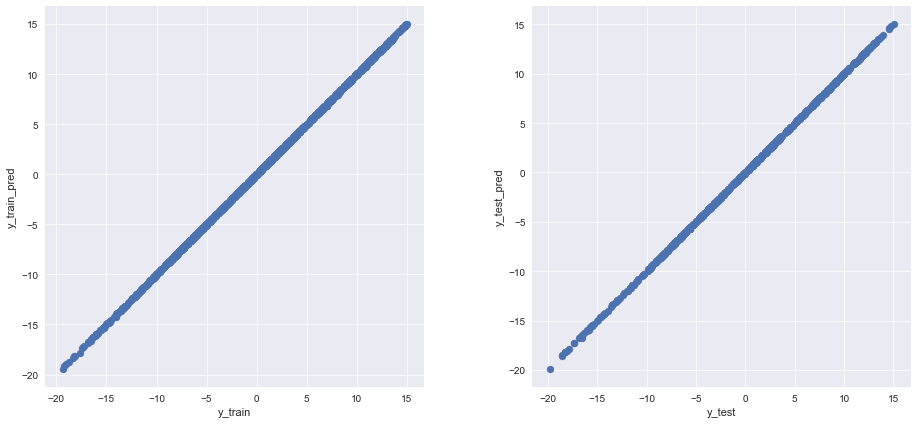

In [9]:
fig, axs = plt.subplots(1,2, figsize=(16, 7))

axs[0].scatter(y_train, y_train_pred)
axs[0].grid(alpha=0.75)
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('y_train')
axs[0].set_ylabel('y_train_pred')

axs[1].scatter(y_test, y_test_pred)
axs[1].grid(alpha=0.75)
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('y_test')
axs[1].set_ylabel('y_test_pred')
plt.show()